In [1]:
import sys
sys.path.append('../Utils')
sys.path.insert(0, '../../FRLC/src/')
from Solve_Slice_test import find_B, solve_V_per_slice, laplacian_from_coords, solve_V_all_slices, find_B_music
from Create_Synthetic import create_data, create_circular_data
from Plot_utils import scatter_pies, plot_cylinder_slices_with_couplings
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [7]:
noises = [2]#, 10]
mus  = [-1, 1, 2, 5, 10, 25, 50, 100]
n_time = 5
lam = 1
import scanpy as sc
from scipy.stats import spearmanr
V_grid = [[None for _ in mus] for _ in noises]          # store solutions if you want
pi_grid =  [[None for _ in mus] for _ in noises]          # store solutions if you want
dom_acc   = np.zeros((len(noises), len(mus)), dtype=float) # MSE over slices
corr = np.zeros((len(noises), len(mus)), dtype=float) # corr over slices
corr_spearman = np.zeros((len(noises), len(mus)), dtype=float)


for (i,noise) in enumerate(noises):
    # adata_synthetic_temp, V_true_temporal, adata, pd_B = create_data(noise=noise,n_time=n_time, stripe=True, stripe_width=2.0, stripe_type=1)
    adata_synthetic_temp, V_true_temporal, adata, pd_B = create_circular_data(noise=noise,n_time=n_time, vary_radius=True, radius=15, sector_center=[0,0])

    # pd_B = pd_B/pd_B.sum(axis=1)
    # for t in range(n_time):
    #     adata_synthetic_temp[t].X = adata_synthetic_temp[t].X/adata_synthetic_temp[t].X.sum(axis=0)

    for j, mu in enumerate(mus):
        V_grid[i][j], pi_grid[i][j], _ = solve_V_all_slices(
            adata_synthetic_temp, pd_B,
            lam=lam, mu=mu, time=None,
            outer_max=100, niter_max=int(1e3), tol=1e-5,
            eta=1e0, verbose=False, alpha=0.9
        )
        # average MSE over slices in `t`
        mse = 0.0
        correct_dom = 0
        total_dom   = 0
        
        # we'll collect all timepoints' V in lists and correlate once at the end
        all_pred = []
        all_true = []
        
        for s in range(n_time):
            # normalize rows of predicted V
            V_grid[i][j][s] = V_grid[i][j][s] / np.sum(V_grid[i][j][s], axis=1, keepdims=True)
        
            # normalize rows of true V in the same way
            V_true_norm = V_true_temporal[s] / np.sum(V_true_temporal[s], axis=1, keepdims=True)
        
            # MSE for this time
            R = V_grid[i][j][s] - V_true_norm
            mse_s = np.mean(R * R)
            mse += mse_s
        
            
        
            # collect flattened vectors for global correlation
            all_pred.append(V_grid[i][j][s].ravel())
            all_true.append(V_true_temporal[s].ravel())
            dom_pred = np.argmax(V_grid[i][j][s], axis=1)
            dom_true = np.argmax(V_true_temporal[s], axis=1)  # normalization doesn't change argmax
        
            correct_dom += np.sum(dom_pred == dom_true)
            total_dom   += dom_pred.shape[0]
        
        
        dom_acc[i, j] = correct_dom / total_dom if total_dom > 0 else np.nan
        
        # concatenate across all times and compute a single correlation
        all_pred_vec = np.concatenate(all_pred)
        all_true_vec = np.concatenate(all_true)
        corr[i, j] = np.corrcoef(all_pred_vec, all_true_vec)[0, 1]
        rho, _ = spearmanr(all_pred_vec, all_true_vec)
        corr_spearman[i, j] = rho

        

[10, 12, 15, 18, 20]


/home/zhaow/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/zhaow/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/zhaow/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/zhaow/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/zhaow/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique

In [50]:
adata_synthetic_temp, V_true_temporal, adata, pd_B = create_circular_data(noise=2,n_time=n_time, vary_radius=True, radius=15, sector_center=[0,0])
counts = []
counts_true = []
for s in range(n_time):
    counts.append(adata_synthetic_temp[s].X.ravel())
    counts_true.append( (V_true_temporal[s] @ pd_B.values).ravel() )
print(np.std(np.concatenate(counts)))
print(np.std(np.concatenate(counts) - np.concatenate(counts_true)))
print(np.std(np.concatenate(counts_true)))

[10, 12, 15, 18, 20]
0.6960383699575595
0.5785816085288815
0.3842058926360144


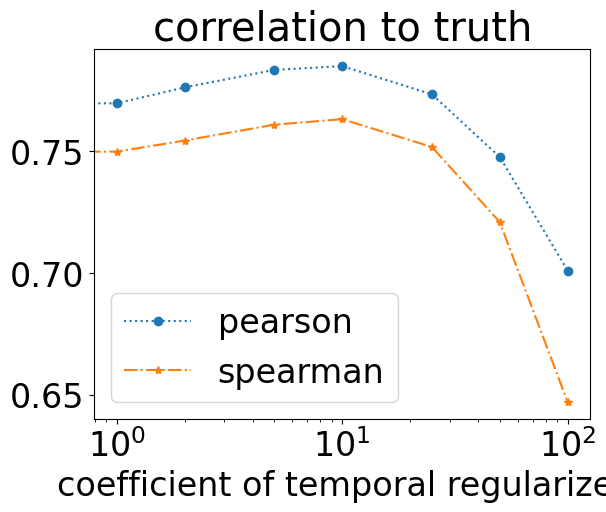

In [51]:
plt.semilogx(mus,corr.T,'o:',label='pearson')
plt.semilogx(mus,corr_spearman.T,'*-.',label='spearman')
plt.xlabel('coefficient of temporal regularizer')
plt.title('correlation to truth')
plt.legend()
# plt.savefig('../Figures/simulations/correlation.png',bbox_inches='tight')

Text(0.5, 1.0, 'cell type annotation accuracy')

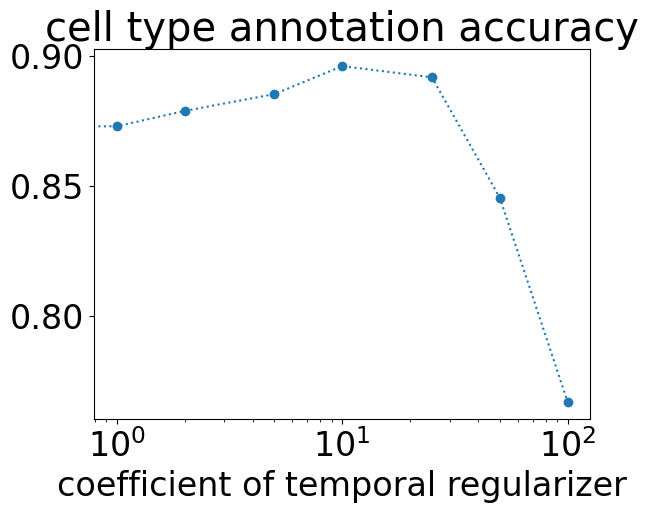

In [52]:
plt.semilogx(mus,dom_acc.T,'o:')
plt.xlabel('coefficient of temporal regularizer')
plt.title('cell type annotation accuracy')
# plt.savefig('../Figures/simulations/accuracy.png',bbox_inches='tight')

In [9]:
adata_synthetic_temp

[AnnData object with n_obs × n_vars = 156 × 5
     obs: 'x', 'y',
 AnnData object with n_obs × n_vars = 216 × 5
     obs: 'x', 'y',
 AnnData object with n_obs × n_vars = 360 × 5
     obs: 'x', 'y',
 AnnData object with n_obs × n_vars = 500 × 5
     obs: 'x', 'y',
 AnnData object with n_obs × n_vars = 624 × 5
     obs: 'x', 'y']

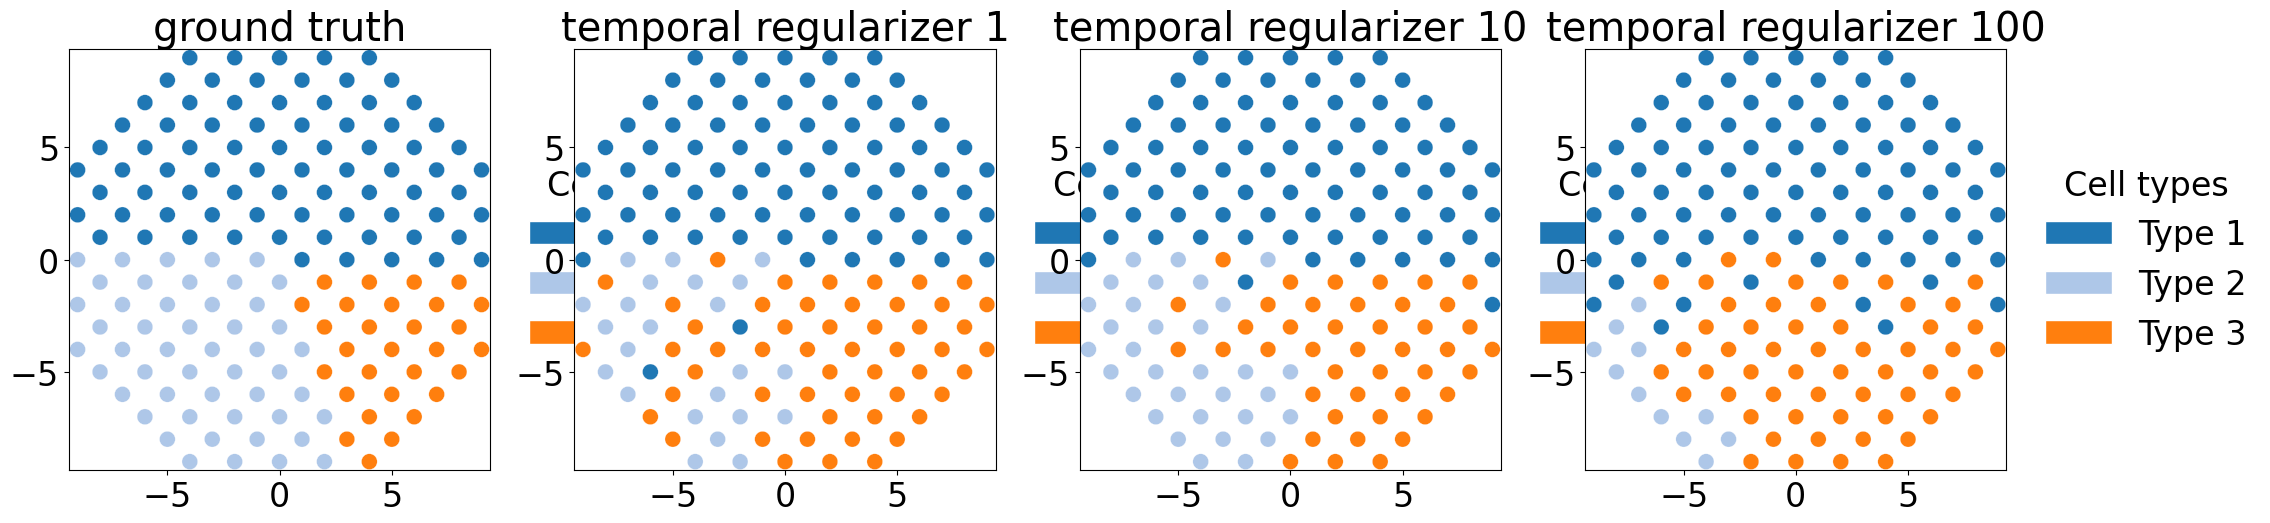

In [53]:
# n_time = 10
# adata_synthetic_temp, V_true_temporal, adata, pd_B = create_circular_data(noise=2.,n_time=n_time, radius=15,vary_radius=True,sector_center=[0,0])
fig, axes = plt.subplots(1, 4, figsize=(25, 7))
# Left: estimated
n_plot = 0
scatter_pies(
        axes[0],
        adata_synthetic_temp[n_plot].obs['x'],
        adata_synthetic_temp[n_plot].obs['y'],
        V_true_temporal[n_plot],
        labels=pd_B.index.to_list(),
        top_n=None
    )
axes[0].set_title('ground truth')


for i in range(1,len(mus),3):
    scatter_pies(
        axes[i//3 + 1],
        adata_synthetic_temp[n_plot].obs['x'],
        adata_synthetic_temp[n_plot].obs['y'],
        V_grid[0][i][n_plot],
        labels=pd_B.index.to_list(),
        top_n=None,
        mode = 'argmax'
    )
    axes[i//3+1].set_title('temporal regularizer '+str(mus[i]))
plt.show()

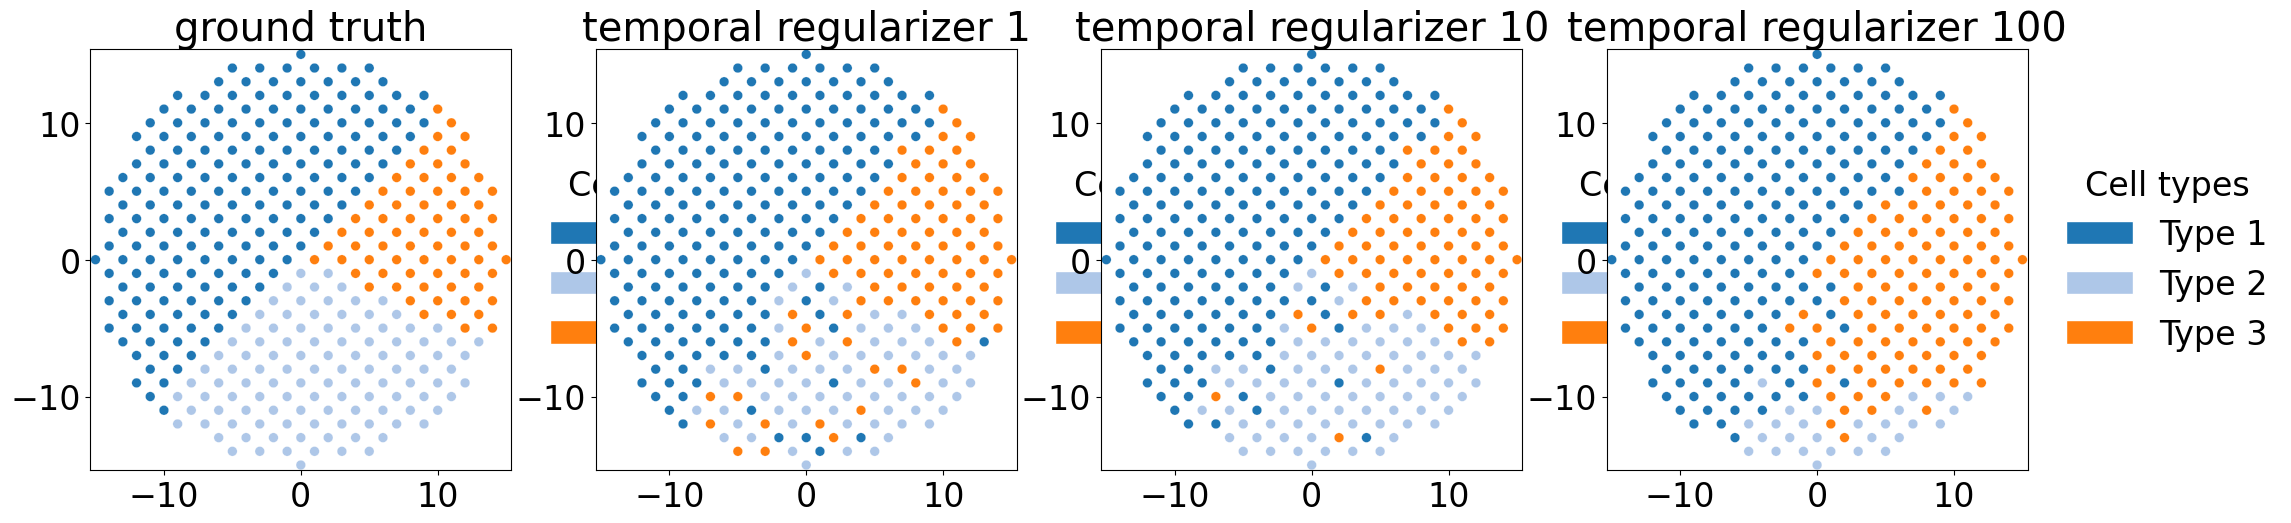

In [54]:
# n_time = 10
# adata_synthetic_temp, V_true_temporal, adata, pd_B = create_circular_data(noise=2.,n_time=n_time, radius=15,vary_radius=True,sector_center=[0,0])
fig, axes = plt.subplots(1, 4, figsize=(25, 7))
# Left: estimated
n_plot = 2
scatter_pies(
        axes[0],
        adata_synthetic_temp[n_plot].obs['x'],
        adata_synthetic_temp[n_plot].obs['y'],
        V_true_temporal[n_plot],
        labels=pd_B.index.to_list(),
        top_n=None
    )
axes[0].set_title('ground truth')


for i in range(1,len(mus),3):
    scatter_pies(
        axes[i//3 + 1],
        adata_synthetic_temp[n_plot].obs['x'],
        adata_synthetic_temp[n_plot].obs['y'],
        V_grid[0][i][n_plot],
        labels=pd_B.index.to_list(),
        top_n=None,
        mode = 'argmax'
    )
    axes[i//3+1].set_title('temporal regularizer '+str(mus[i]))
plt.show()

In [13]:
adata_synthetic_temp

[AnnData object with n_obs × n_vars = 156 × 5
     obs: 'x', 'y',
 AnnData object with n_obs × n_vars = 216 × 5
     obs: 'x', 'y',
 AnnData object with n_obs × n_vars = 360 × 5
     obs: 'x', 'y',
 AnnData object with n_obs × n_vars = 500 × 5
     obs: 'x', 'y',
 AnnData object with n_obs × n_vars = 624 × 5
     obs: 'x', 'y']

In [40]:
V_true_temporal[0].shape

(156, 3)

In [41]:
X_true.shape

(360, 2)

[10, 12, 15, 18, 20]
(156, 5)
2.715233564376831


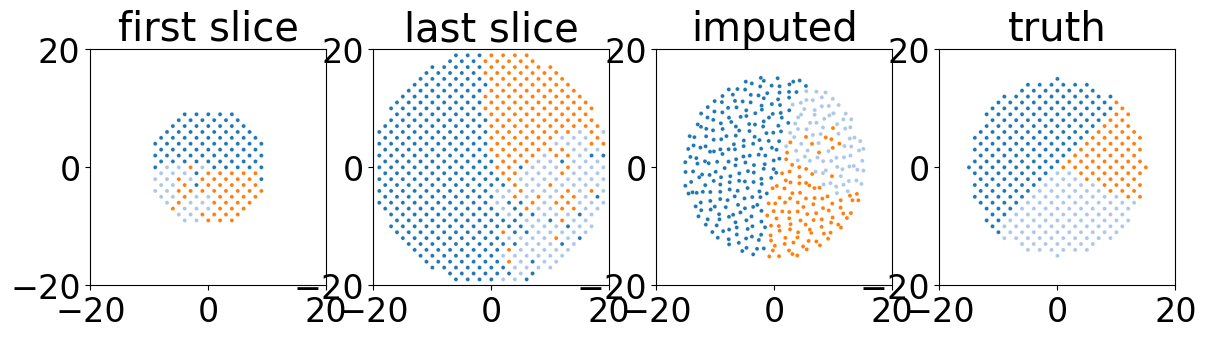

In [55]:
from Impute import impute_slice_fgw_barycenter, classical_mds

n_time = 5
adata_synthetic_temp, V_true_temporal, adata, pd_B = create_circular_data(noise=2.,n_time=n_time, radius=15, vary_radius=True, sector_center=[0,0])
print(adata_synthetic_temp[0].shape)

X1 = np.vstack([ adata_synthetic_temp[-1].obs['x'], adata_synthetic_temp[-1].obs['y']]).T
X0 = np.vstack([ adata_synthetic_temp[0].obs['x'], adata_synthetic_temp[0].obs['y']]).T
X_true = np.vstack([ adata_synthetic_temp[2].obs['x'], adata_synthetic_temp[2].obs['y']]).T
Y_true =  V_true_temporal[2]
Y1 = V_grid[0][3][-1] #
# Y1 = V_true_temporal[-1]
Y0 = V_grid[0][3][0] #
# Y0 = V_true_temporal[0]

# Y1 = adata_synthetic_temp[8].X
# Y0 = adata_synthetic_temp[0].X

import time

t = time.time()

X_bar, Y_bar, C_bar, log = impute_slice_fgw_barycenter(
    X0, Y0, X1, Y1,
    t=0.5,          # midpoint
    N_bary=None,    # default size ~ average of n0, n1
    alpha=0.5,      # balance spatial structure vs features
    epsilon=0.001,
    random_state=42,
)
# do stuff
elapsed = time.time() - t
print(elapsed)

fig, axes = plt.subplots(1, 4, figsize=(14, 7))
scatter_pies(
        axes[0],
        X0[:,0],X0[:,1],
        Y0,
        labels=pd_B.index.to_list(),
        top_n=None,
        mode = 'argmax'
    )

axes[0].set_title('first slice')

scatter_pies(
        axes[1],
        X1[:,0],X1[:,1],
        Y1,
        labels=pd_B.index.to_list(),
        top_n=None,
        mode = 'argmax'
    )
axes[1].set_title('last slice')


scatter_pies(
        axes[2],
        X_bar[:,0],X_bar[:,1],
        Y_bar,
        labels=pd_B.index.to_list(),
        top_n=None,
        mode = 'argmax'
    )
axes[2].set_title('imputed')

scatter_pies(
        axes[3],
        X_true[:,0],X_true[:,1],
        Y_true,
        labels=pd_B.index.to_list(),
        top_n=None,
        mode = 'argmax'
    )
axes[3].set_title('truth')

for i in range(4):
    axes[i].set_xlim([-20,20])
    axes[i].set_ylim([-20,20])
    axes[i].get_legend().remove()

[10, 12, 15, 18, 20]
(156, 5)
2.821627616882324


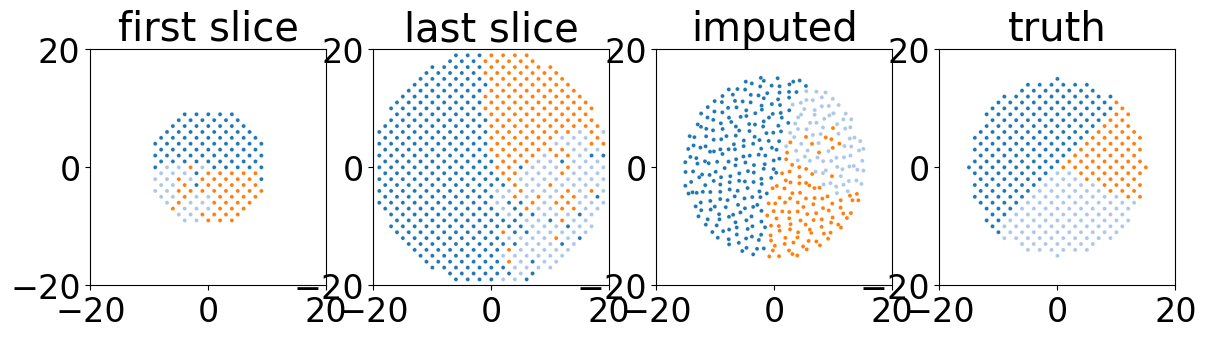

In [59]:
adata_synthetic_temp, V_true_temporal, adata, pd_B =  create_circular_data(noise=2.,n_time=n_time, radius=15, vary_radius=True, sector_center=[0,0])
print(adata_synthetic_temp[0].shape)

X1 = np.vstack([ adata_synthetic_temp[-1].obs['x'], adata_synthetic_temp[-1].obs['y']]).T
X0 = np.vstack([ adata_synthetic_temp[0].obs['x'], adata_synthetic_temp[0].obs['y']]).T
X_true = np.vstack([ adata_synthetic_temp[2].obs['x'], adata_synthetic_temp[2].obs['y']]).T
Y_true =  V_true_temporal[2]
Y1 = V_grid[0][3][-1] #
# Y1 = V_true_temporal[-1]
Y0 = V_grid[0][3][0] #
# Y0 = V_true_temporal[0]

# Y1 = adata_synthetic_temp[8].X
# Y0 = adata_synthetic_temp[0].X

import time

t = time.time()

X_bar, Y_bar, C_bar, log = impute_slice_fgw_barycenter(
    X0, Y0, X1, Y1,
    t=0.5,          # midpoint
    N_bary=None,    # default size ~ average of n0, n1
    alpha=0.5,      # balance spatial structure vs features
    epsilon=0.001,
    random_state=42,
)
# do stuff
elapsed = time.time() - t
print(elapsed)

fig, axes = plt.subplots(1, 4, figsize=(14, 7))
scatter_pies(
        axes[0],
        X0[:,0],X0[:,1],
        Y0,
        labels=pd_B.index.to_list(),
        top_n=None,
        mode = 'argmax'
    )

axes[0].set_title('first slice')

scatter_pies(
        axes[1],
        X1[:,0],X1[:,1],
        Y1,
        labels=pd_B.index.to_list(),
        top_n=None,
        mode = 'argmax'
    )
axes[1].set_title('last slice')


scatter_pies(
        axes[2],
        X_bar[:,0],X_bar[:,1],
        Y_bar,
        labels=pd_B.index.to_list(),
        top_n=None,
        mode = 'argmax'
    )
axes[2].set_title('imputed')

scatter_pies(
        axes[3],
        X_true[:,0],X_true[:,1],
        Y_true,
        labels=pd_B.index.to_list(),
        top_n=None,
        mode = 'argmax'
    )
axes[3].set_title('truth')

for i in range(4):
    axes[i].set_xlim([-20,20])
    axes[i].set_ylim([-20,20])
    axes[i].get_legend().remove()

[10, 12, 15, 18, 20]
(156, 5)


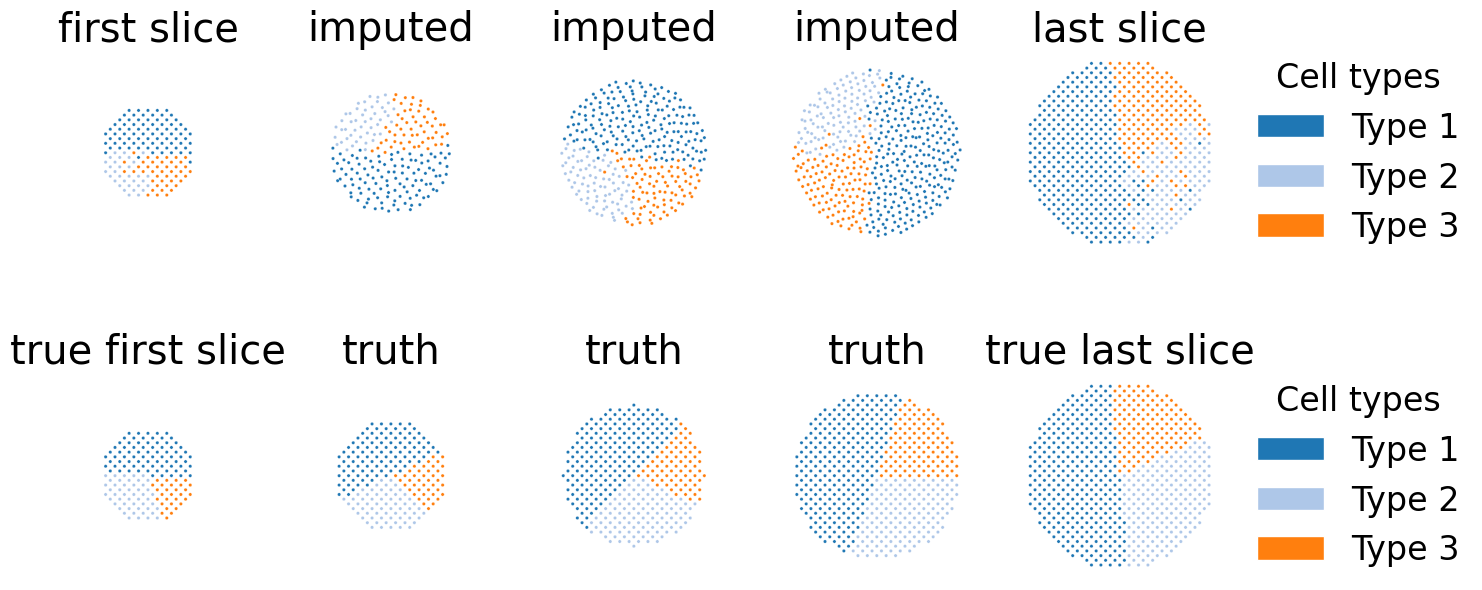

In [60]:
from Impute import gp_impute_spots_cross_slice,  impute_slice_fgw_barycenter, classical_mds

n_time = 5
adata_synthetic_temp, V_true_temporal, adata, pd_B = create_circular_data(noise=2.,n_time=n_time, radius=15, vary_radius=True, sector_center=[0,0])
print(adata_synthetic_temp[0].shape)

X1 = np.vstack([ adata_synthetic_temp[-1].obs['x'], adata_synthetic_temp[-1].obs['y']]).T
X0 = np.vstack([ adata_synthetic_temp[0].obs['x'], adata_synthetic_temp[0].obs['y']]).T

Y1 = V_grid[0][4][-1] #
# Y1 = V_true_temporal[-1]
Y0 = V_grid[0][4][0] #


fig, axes = plt.subplots(2, 5, figsize=(15, 7))
plt.rcParams['font.size'] = 24
scatter_pies(
        axes[0,0],
        X0[:,0],X0[:,1],
        Y0,
        labels=pd_B.index.to_list(),
        top_n=None,
        mode = 'argmax'
    )

axes[0,0].set_title('first slice')

scatter_pies(
        axes[0,4],
        X1[:,0],X1[:,1],
        Y1,
        labels=pd_B.index.to_list(),
        top_n=None,
        mode = 'argmax'
    )
axes[0,4].set_title('last slice')

scatter_pies(
        axes[1,0],
        X0[:,0],X0[:,1],
        V_true_temporal[0],
        labels=pd_B.index.to_list(),
        top_n=None,
        mode = 'argmax'
    )

axes[1,0].set_title('true first slice')

scatter_pies(
        axes[1,4],
        X1[:,0],X1[:,1],
        V_true_temporal[-1],
        labels=pd_B.index.to_list(),
        top_n=None,
        mode = 'argmax'
    )
axes[1,4].set_title('true last slice')

for i in range(3):

    X_bar, Y_bar, C_bar, log = impute_slice_fgw_barycenter(
        X0, Y0, X1, Y1,
        t=0.25*(i+1),          # midpoint
        N_bary=adata_synthetic_temp[i+1].obs['x'].shape[0],    # default size ~ average of n0, n1
        alpha=0.5,      # balance spatial structure vs features
        epsilon=0.001,
        random_state=42,
    )
    

    
    scatter_pies(
            axes[0,i+1],
            X_bar[:,0],X_bar[:,1],
            Y_bar,
            labels=pd_B.index.to_list(),
            top_n=None,
            mode = 'argmax'
        )
    axes[0,i+1].set_title('imputed')

    X_true = np.vstack([ adata_synthetic_temp[i+1].obs['x'], adata_synthetic_temp[i+1].obs['y']]).T
    Y_true =  V_true_temporal[i+1]
    scatter_pies(
            axes[1,i+1],
            X_true[:,0],X_true[:,1],
            Y_true,
            labels=pd_B.index.to_list(),
            top_n=None,
            mode = 'argmax'
        )
    axes[1,i+1].set_title('truth')

for i in range(2):
    for j in range(5):
        axes[i,j].set_xlim([-22,22])
        axes[i,j].set_ylim([-22,22])
        if j > 0 and j < 4:
            axes[i,j].get_legend().remove()
            axes[i, j].set_axis_off()
        elif j == 0:
            axes[i,j].get_legend().remove()
            axes[i, j].set_axis_off()
        else:
            axes[i, j].set_axis_off()

plt.tight_layout()
# plt.savefig('../Figures/simulations/imputation.png',bbox_inches='tight')


In [65]:
len(V_true_temporal)

5

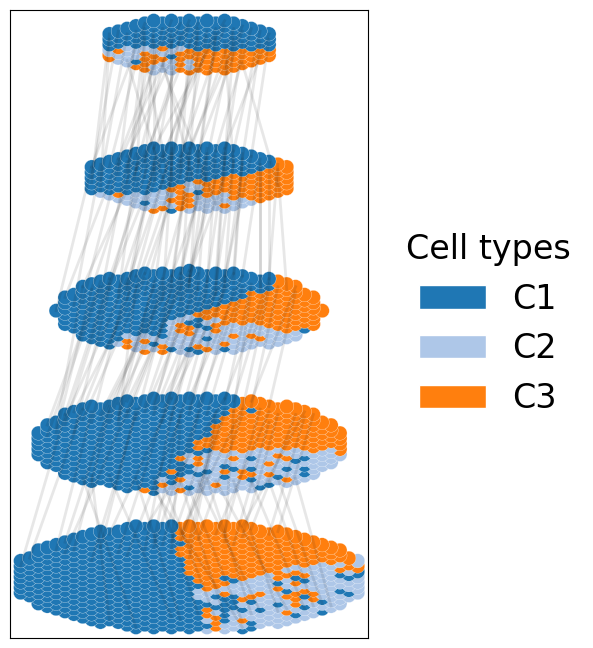

In [69]:

fig, ax = plot_cylinder_slices_with_couplings(
    adata_synthetic_temp,
    V_grid[0][1],
    pi_grid[0][1],
    scatter_pies,
    t_start=0,
    t_end=4,
    y_gap = 15,
    y_scale = 0.3,
    mode = 'argmax',
    min_weight=0.9,
    max_edges_per_pair = 50,
    pie_radius=0.8,
    figsize=(8,7)
)
# plt.savefig('../Figures/simulations/temporal.png',bbox_inches='tight')
plt.show()


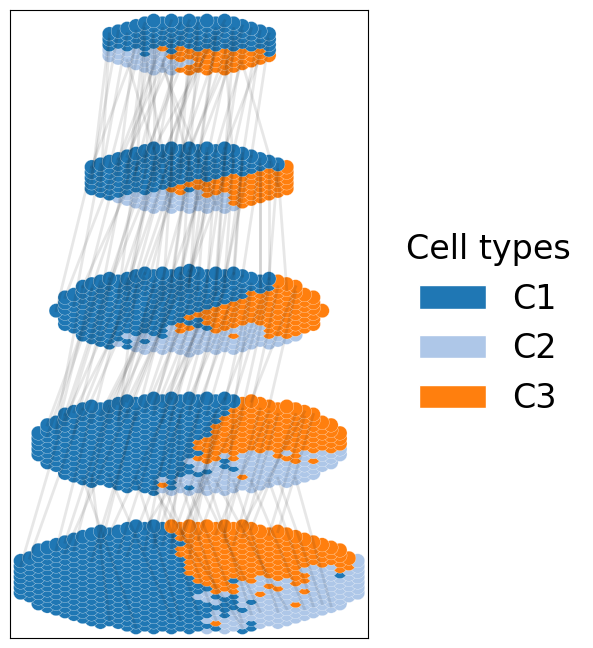

In [71]:

fig, ax = plot_cylinder_slices_with_couplings(
    adata_synthetic_temp,
    V_grid[0][5],
    pi_grid[0][5],
    scatter_pies,
    t_start=0,
    t_end=4,
    y_gap = 15,
    y_scale = 0.3,
    mode = 'argmax',
    min_weight=0.9,
    max_edges_per_pair = 50,
    pie_radius=0.8,
    figsize=(8,7),
)
# plt.savefig('../Figures/simulations/no_temporal.png',bbox_inches='tight')
plt.show()

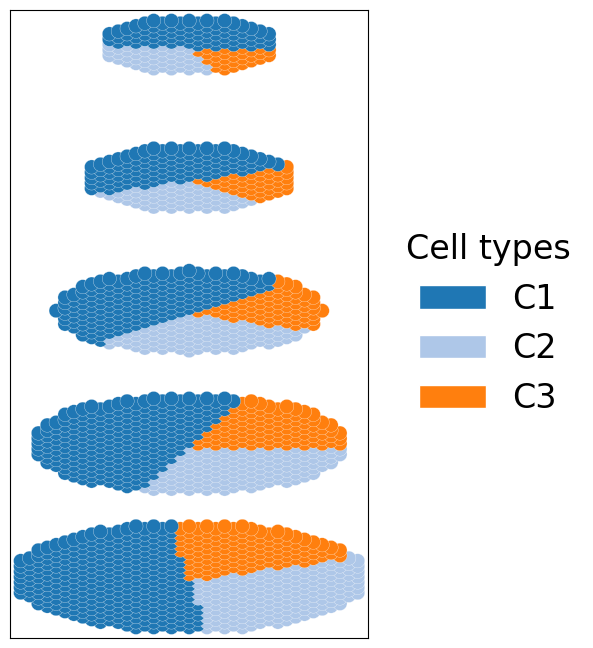

In [73]:

fig, ax = plot_cylinder_slices_with_couplings(
    adata_synthetic_temp,
    V_true_temporal,
    pi_grid[0][5],
    scatter_pies,
    t_start=0,
    t_end=4,
    y_gap = 15,
    y_scale = 0.3,
    mode = 'argmax',
    min_weight=0.9,
    max_edges_per_pair = 0,
    pie_radius=0.8,
    figsize=(8,7),
)
# plt.savefig('../Figures/simulations/truth.png',bbox_inches='tight')
plt.show()